## Import the Packages

In [1]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, Input
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Loading

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5...
/ [1/1 files][257.5 MiB/257.5 MiB] 100% Done                                    
Operation completed over 1 objects/257.5 MiB.                                    


In [4]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5...
- [1/1 files][ 32.5 MiB/ 32.5 MiB] 100% Done                                    
Operation completed over 1 objects/32.5 MiB.                                     


In [5]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5...
- [1/1 files][ 31.9 MiB/ 31.9 MiB] 100% Done                                    
Operation completed over 1 objects/31.9 MiB.                                     


In [0]:
def load_dataset():
    train_dataset = h5py.File('sample_data/train.hdf5', "r")
    X_train = np.array(train_dataset["data_x"][:]) # your train set features
    y_train = np.array(train_dataset["data_y"][:]) # your train set labels

    valid_dataset = h5py.File('sample_data/valid.hdf5', "r")
    X_valid = np.array(valid_dataset["data_x"][:]) # your valid set features
    y_valid = np.array(valid_dataset["data_y"][:]) # your valid set labels
    
    test_dataset = h5py.File('sample_data/test.hdf5', "r")
    X_test = np.array(test_dataset["data_x"][:]) # your test set features
    y_test = np.array(test_dataset["data_y"][:]) # your test set labels

    classes = np.array(['01_TUMOR','02_STROMA','03_COMPLEX','04_LYMPHO','05_DEBRIS','06_MUCOSA','07_ADIPOSE','08_EMPTY']) # the list of classes

    return X_train, y_train, X_valid, y_valid, X_test, y_test, classes

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test, classes = load_dataset()

y = 3, it's a '03_COMPLEX' picture.


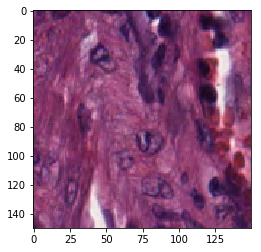

In [8]:
index = 1000
plt.imshow(X_train[index])
print ("y = " + str(y_train[index]) + ", it's a '" + classes[y_train[index-1]] +  "' picture.")


In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000,)
(496, 150, 150, 3)
(496,)
(504, 150, 150, 3)
(504,)


## Data Pre-processing

In [0]:
# Resizing images to 1-D array to be fit into NN
X_train = X_train.reshape(4000, 150, 150, 3)
X_valid = X_valid.reshape(496, 150, 150, 3)
X_test = X_test.reshape(504, 150, 150, 3)

# Converting the data to float type 
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Scaling the data
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

num_classes = 8

# Converting the output to categorical variables
y_train = to_categorical(y_train-1,num_classes)
y_valid = to_categorical(y_valid-1,num_classes)
y_test = to_categorical(y_test-1, num_classes)

In [11]:
# Chacking the train, validation and test sets

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000, 8)
(496, 150, 150, 3)
(496, 8)
(504, 150, 150, 3)
(504, 8)


## Create and Compile the ResNet Model

In [12]:
# LOAD ResNet50
input_tensor = Input(shape=(150,150,3))
model_resnet_conv = ResNet50(weights='imagenet', 
                           include_top=False,
                           input_tensor=input_tensor)
model_resnet_conv.summary()

W0814 00:18:05.574655 139662417696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 00:18:05.595870 139662417696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 00:18:05.602390 139662417696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0814 00:18:05.627294 139662417696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 00:18:05.628100

94658560/94653016 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________

Reference link: https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

In [13]:
# Make ResNet model layers as non trainable
for layer in model_resnet_conv.layers:
    layer.trainable = False

# Create our own input format
input = Input(shape=(150,150,3),name = 'image_input')   

# Use the generated model 
output_resnet_conv = model_resnet_conv(input)

# Add the flatten layer and output layer
x = Flatten(name='flatten')(output_resnet_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(8, activation='softmax', name='predictions')(x)

# Create our own model
my_model1 = Model(input=input, output=x)
my_model1.summary()
my_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
W0814 00:18:20.854715 139662417696640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               26214912  
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
predictions (Dense)          (None, 8)                 1032      
Total params: 49,869,320
Trainable params: 26,281,608
Non-trainable params: 23,587,712
_______________________________________________________

## Model Without Data Augmentation

In [0]:
callbacks1 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [15]:
batch_size = 32
nb_classes = 8
nb_epoch = 20

# fit the model
history1 = my_model1.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=nb_epoch,
           callbacks=callbacks1,
           validation_data=(X_valid, y_valid))

W0814 00:18:21.000909 139662417696640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4000 samples, validate on 496 samples
Epoch 1/20
4000/4000 [==============================] - 17s 4ms/step - loss: 10.3807 - acc: 0.3465 - val_loss: 13.6499 - val_acc: 0.1250
Epoch 2/20
4000/4000 [==============================] - 11s 3ms/step - loss: 9.4534 - acc: 0.4085 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 3/20
4000/4000 [==============================] - 11s 3ms/step - loss: 9.3751 - acc: 0.4158 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 4/20
4000/4000 [==============================] - 12s 3ms/step - loss: 9.1172 - acc: 0.4335 - val_loss: 14.1033 - val_acc: 0.1250


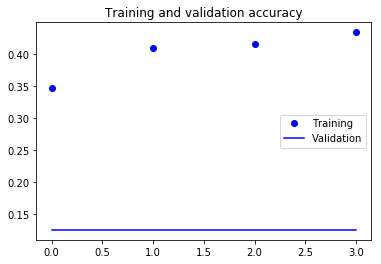

In [16]:
plt.plot(history1.history['acc'], 'bo', label='Training')
plt.plot(history1.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model1 = load_model('best_model1.h5')

In [18]:
score1 = opt_model1.evaluate(X_test,y_test)

504/504 [==============================] - 3s 6ms/step


In [19]:
score1

[13.644961267976662, 0.125]

## Model with Data Augmentation

### Aug1

In [20]:
my_model2 = Model(input=input, output=x)
my_model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen1.fit(X_train)

In [0]:
callbacks2 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [23]:
# Fit the model on the batches generated by datagen.flow
history2 = my_model2.fit_generator(datagen1.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks2,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 24s 189ms/step - loss: 9.2330 - acc: 0.4263 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/20
125/125 [==============================] - 18s 146ms/step - loss: 9.6610 - acc: 0.3992 - val_loss: 14.9316 - val_acc: 0.0040
Epoch 3/20
125/125 [==============================] - 21s 164ms/step - loss: 9.1839 - acc: 0.4295 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 4/20
125/125 [==============================] - 21s 164ms/step - loss: 9.5299 - acc: 0.4078 - val_loss: 14.1033 - val_acc: 0.1250


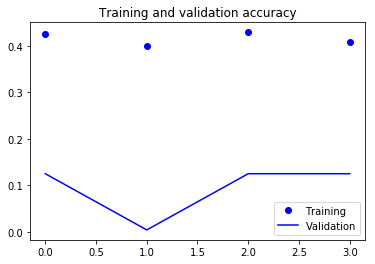

In [24]:
plt.plot(history2.history['acc'], 'bo', label='Training')
plt.plot(history2.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model2 = load_model('best_model2.h5')

In [26]:
score2 = opt_model2.evaluate(X_test,y_test)

504/504 [==============================] - 3s 7ms/step


In [27]:
score2

[14.10333350158873, 0.125]

### Aug2

In [28]:
my_model3 = Model(input=input, output=x)
my_model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen2.fit(X_train)

In [0]:
callbacks3 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [31]:
# Fit the model on the batches generated by datagen.flow
history3 = my_model3.fit_generator(datagen2.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks3,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 25s 203ms/step - loss: 9.1873 - acc: 0.4295 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/20
125/125 [==============================] - 17s 140ms/step - loss: 9.2542 - acc: 0.4248 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 3/20
125/125 [==============================] - 20s 163ms/step - loss: 8.9748 - acc: 0.4425 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 4/20
125/125 [==============================] - 20s 164ms/step - loss: 9.2560 - acc: 0.4255 - val_loss: 14.1033 - val_acc: 0.1250


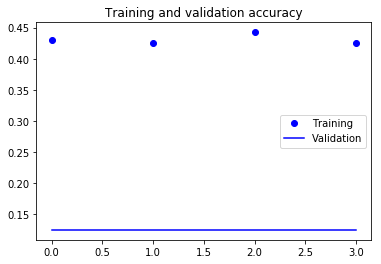

In [32]:
plt.plot(history3.history['acc'], 'bo', label='Training')
plt.plot(history3.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model3 = load_model('best_model3.h5')

In [34]:
score3 = opt_model3.evaluate(X_test,y_test)

504/504 [==============================] - 4s 8ms/step


In [35]:
score3

[14.10333350158873, 0.125]